In [3]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from ops import *
from utils import *

In [4]:
DATA_PATH      = "./aligned_celebA/" # Path to the dataset with celebA faces
Z_DIM=100 # Dimension of face's manifold
IMAGE_SIZE=32 # Shapes of input image   (laptop goes out of memory when running program for image size 64)
BATCH_SIZE=64 # Batch size
N_CHANNELS = 3 # Number channels of input image

Ntrain        = 5
Ntest         = 5
nm_imgs       = np.sort(os.listdir(DATA_PATH))
## name of the jpg files for training set
nm_imgs_train = nm_imgs[:Ntrain]
## name of the jpg files for the testing data
nm_imgs_test  = nm_imgs[Ntrain:Ntrain + Ntest]
img_shape     = (IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS)

def get_npdata(nm_imgs_train):
    X_train = []
    for i, myid in enumerate(nm_imgs_train):
        image = load_img(DATA_PATH + "/" + myid,
                         target_size=img_shape[:2])
        image = img_to_array(image)/255.0
        X_train.append(image)
    X_train = np.array(X_train)
    return(X_train)

X_train = get_npdata(nm_imgs_train)
print("X_train.shape = {}".format(X_train.shape))

X_test  = get_npdata(nm_imgs_test)
print("X_test.shape = {}".format(X_test.shape))

X_train.shape = (5, 32, 32, 3)
X_test.shape = (5, 32, 32, 3)


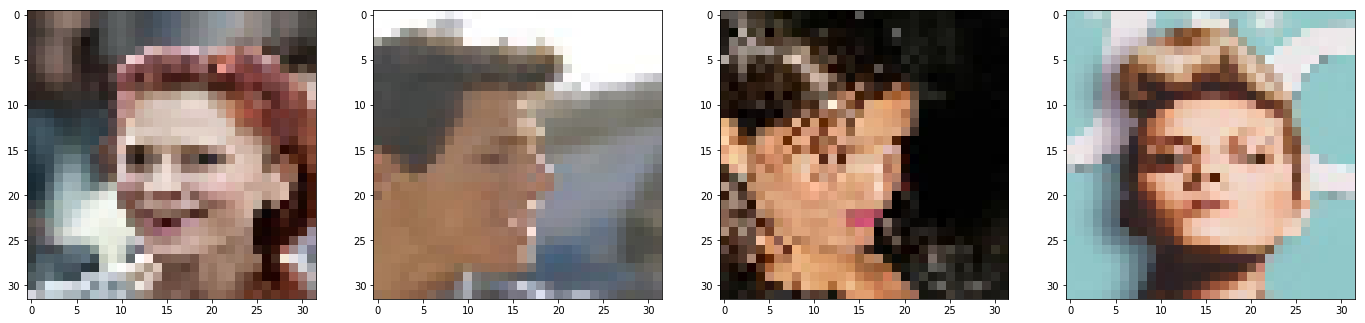

In [5]:
fig = plt.figure(figsize=(30,10))
nplot = 5
for count in range(1,nplot):
    ax = fig.add_subplot(1,nplot,count)
    ax.imshow(X_train[count])
plt.show()

In [6]:
import numpy as np
from keras import layers, models  # using Keras to build model
from keras.optimizers import Adam

## optimizer
optimizer = Adam(5e-5, 0.5)

def build_generator(img_shape, noise_shape = (100,)):
    '''
    noise_shape : the dimension of the input vector for the generator
    img_shape   : the dimension of the output
    '''
    ## latent variable as input
    input_noise = layers.Input(shape=noise_shape) 
    d = layers.Dense(1024, activation="relu")(input_noise) 
    d = layers.Dense(1024, activation="relu")(input_noise) 
    d = layers.Dense(128*8*8, activation="relu")(d)
    d = layers.Reshape((8,8,128))(d)
    
    d = layers.Conv2DTranspose(128, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
    d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_4")(d) ## 16,16


    d = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
    d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_5")(d) ## 32,32
    
#    d = layers.Conv2DTranspose(8, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
#    d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_6")(d) ## 64,64
    
#    d = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  strides=(2,2) , use_bias=False)(d)
#    d = layers.Conv2D( 64  , ( 1 , 1 ) , activation='relu' , padding='same', name="block_7")(d) ## 128,128
    
    img = layers.Conv2D( 3 , ( 1 , 1 ) , activation='sigmoid' , padding='same', name="final_block")(d) ## 32,32
    model = models.Model(input_noise, img)
    model.summary() 
    return(model)

## Set the dimension of latent variables to be 100
noise_shape = (100,)

generator = build_generator(img_shape, noise_shape = noise_shape)

generator.compile(loss='binary_crossentropy', optimizer=optimizer)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              103424    
_________________________________________________________________
dense_3 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       65536     
_________________________________________________________________
block_4 (Conv2D)             (None, 16, 16, 64)        8256      
_________________________________________________________________
conv

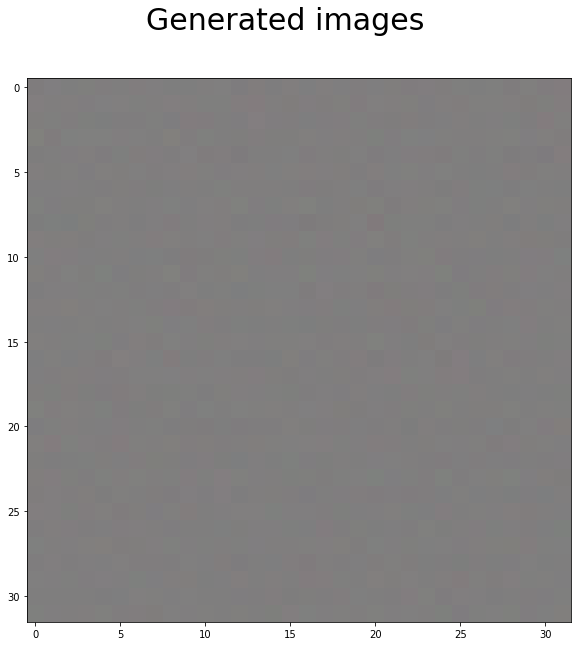

In [7]:
def get_noise(nsample, nlatent_dim=100):
    noise = np.random.normal(0, 1, (nsample,nlatent_dim))
    return(noise)

def plot_generated_images(noise,path_save=None,titleadd=""):
    imgs = generator.predict(noise)
    fig = plt.figure(figsize=(10,10))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1,nsample,i+1)
        ax.imshow(img)
    fig.suptitle("Generated images "+titleadd,fontsize=30)
    
    if path_save is not None:
        plt.savefig(path_save,
                    bbox_inches='tight',
                    pad_inches=0)
        plt.close()
    else:
        plt.show()

nsample = 1
noise = get_noise(nsample=nsample, nlatent_dim=noise_shape[0])
plot_generated_images(noise)

In [8]:
def build_discriminator(img_shape,noutput=1):
    input_img = layers.Input(shape=img_shape)
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1')(input_img)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(1, 1), name='block4_pool')(x)
    
#    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block6_conv1')(x)
#    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='block6_conv2')(x)
#    x = layers.MaxPooling2D((2, 2), strides=(1, 1), name='block6_pool')(x)

    
    x         = layers.Flatten()(x)
    x         = layers.Dense(1024,      activation="relu")(x)
    out       = layers.Dense(noutput,   activation='sigmoid')(x)
    model     = models.Model(input_img, out)
    
    return model

discriminator  = build_discriminator(img_shape)
discriminator.compile(loss      = 'binary_crossentropy', 
                      optimizer = optimizer,
                      metrics   = ['accuracy'])

discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 32)        896       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 32)        9248      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 64)        18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 64)          0         
__________

In [9]:
z = layers.Input(shape=noise_shape)
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = models.Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 3)         8584515   
_________________________________________________________________
model_2 (Model)              (None, 1)                 6711585   
Total params: 15,296,100
Trainable params: 8,584,515
Non-trainable params: 6,711,585
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.


C:\Anaconda\envs\jupyter\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 00000 [D loss: 0.713, acc.: 050.0%] [G loss: 0.664]


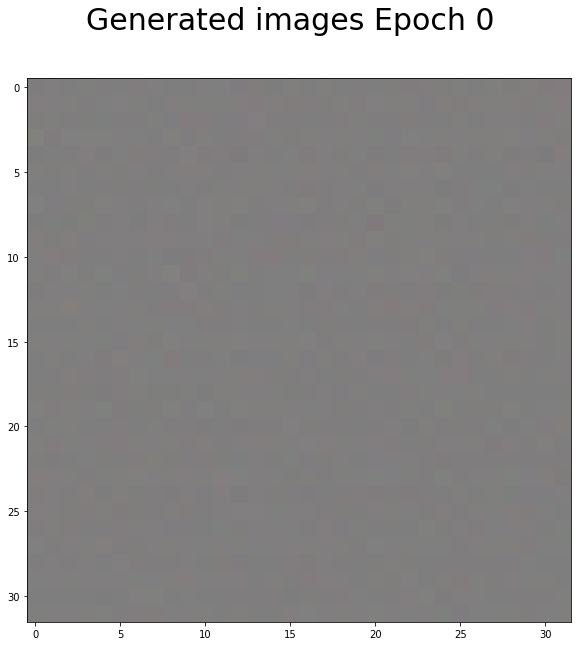

Epoch 00100 [D loss: 0.208, acc.: 100.0%] [G loss: 1.678]
Epoch 00200 [D loss: 0.127, acc.: 100.0%] [G loss: 2.730]
Epoch 00300 [D loss: 0.258, acc.: 092.2%] [G loss: 3.257]
Epoch 00400 [D loss: 0.189, acc.: 100.0%] [G loss: 3.150]
Epoch 00500 [D loss: 0.194, acc.: 089.1%] [G loss: 2.765]
Epoch 00600 [D loss: 0.174, acc.: 093.8%] [G loss: 3.098]
Epoch 00700 [D loss: 0.220, acc.: 090.6%] [G loss: 2.712]
Epoch 00800 [D loss: 0.102, acc.: 096.9%] [G loss: 3.009]
Epoch 00900 [D loss: 0.240, acc.: 090.6%] [G loss: 2.422]
Epoch 01000 [D loss: 0.255, acc.: 090.6%] [G loss: 2.416]


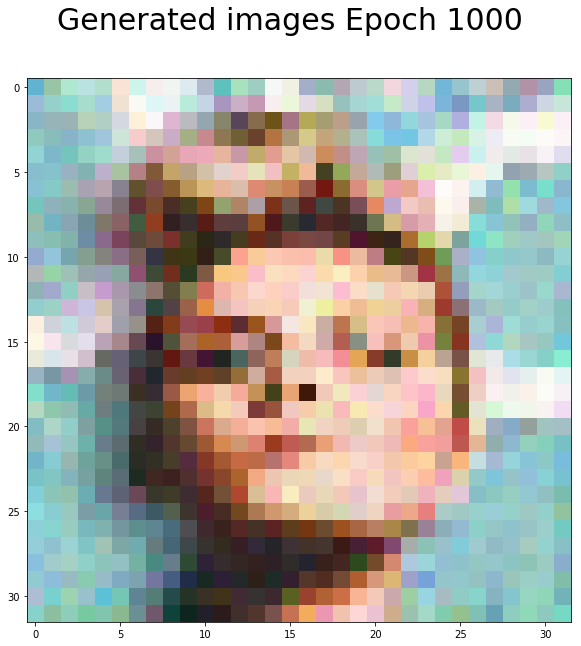

----------
Time took: 15.41 min


In [11]:
epochs = 1001
dir_result="./result/"
def train(models, X_train, noise_plot, dir_result, epochs, batch_size):
        '''
        models     : tuple containins three tensors, (combined, discriminator, generator)
        X_train    : np.array containing images (Nsample, height, width, Nchannels)
        noise_plot : np.array of size (Nrandom_sample_to_plot, hidden unit length)
        dir_result : the location where the generated plots for noise_plot are saved 
        
        '''
        combined, discriminator, generator = models
        nlatent_dim = noise_plot.shape[1]
        half_batch  = int(batch_size / 2)
        history = []
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
            noise = get_noise(half_batch, nlatent_dim)

            # Generate a half batch of new images
            gen_imgs = generator.predict(noise)

            
            # Train the discriminator q: better to mix them together?
            d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))      # D tries to make real imgs predicted as 1
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))) # D tries to make fake imgs predicted as 0
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = get_noise(batch_size, nlatent_dim)

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = (np.array([1] * batch_size)).reshape(batch_size,1)   # G tries to make fake imgs predicted as 1
            
            # Train the generator
            g_loss = combined.train_on_batch(noise, valid_y) # G tries to make fake imgs predicted as 1

            history.append({"D":d_loss[0],"G":g_loss})
            
            if epoch % 100 == 0:
                # Plot the progress
                print ("Epoch {:05.0f} [D loss: {:4.3f}, acc.: {:05.1f}%] [G loss: {:4.3f}]".format(
                    epoch, d_loss[0], 100*d_loss[1], g_loss))
                plot_generated_images(noise_plot,
                                      path_save=dir_result+"/image_{:05.0f}.png".format(epoch),
                                      titleadd="Epoch {}".format(epoch))
            if epoch % 1000 == 0:
                plot_generated_images(noise_plot,
                                      titleadd="Epoch {}".format(epoch))
                        
        return(history)

try:
    os.mkdir(dir_result)
except:
    pass
    
start_time = time.time()

_models = combined, discriminator, generator          

history = train(_models, X_train, noise, dir_result,epochs, BATCH_SIZE)
end_time = time.time()
print("-"*10)
print("Time took: {:4.2f} min".format((end_time - start_time)/60))